# Project creative extension

In this notebook can be found the P4 milestone of the project, a creative extension of the paper *Comparing Random Forest with Logistic Regression for Predicting Class-Imbalanced Civil War Onset Data* by David Muchlinski, David Siroky, Jingrui He and Matthew Kocher. 

The research questions we are trying to answer with this notebook are:
- Do the best predictors of civil war onset evolve throughout the years and if so, what does this allude to ?
- Can the duration of the conflict be predicted and if so, what enablers of peace can be hypothesised ?
- Are artificial neural networks even better predictors, and do they corroborate or question the previous analysis ?

Here is the abstract of the content of this notebook, as well as the datasets and methods which will be used.

## Abstract

The takeaways from the original paper are that algorithmic approaches offer a higher predictive power of civil war onset than traditional techniques, an asset used to corroborate some previous causal conclusions, and to question others. We propose to further exploit the derived algorithmic model in order to analyze some temporal aspects of these conflicts. Namely, we will study the evolution of the best predictors across the years. Also, we will tackle the arguably as-important issue of the ending of these conflicts, to gain an insight into the enablers of peace. To do so we will manipulate the data, and leverage the same algorithmic approach to predict ending. Finally, we will use another model, namely artificial neural networks, to study if predictive accuracy can be enhanced further. In the same spirit of the paper, permutation importance will then be used to strengthen or emit new hypotheses on our causal analysis.


## Dataset:

- **CWD**: Civil War Dataset, the dataset already used by the paper. We will use this dataset for the analysis of the evolution of civil war predictors over the years. This dataset was already previously used. All replication materials from the original paper can be found [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/KRKWK8).

## Methods:

- **Temporal change of best predictors for civil war**: We will analyze the evolution of predictors for civil war over the years by grouping the events in bins of 15 years periods (using the permutation importance). We will then analyze if there is a significant change of predictors over the years. We will also do clustering on the features of the events, to see if we can find some temporal dependencies and on which periods.
- **Analysis of civil war ending**: Following a similar approach to that of the paper, we will fit a Random Forest regressor to predict the ending of a conflict. Evaluating the predictive performance of the model will first give us an insight as to how well the features of the CWD dataset can encapsulate the complex factors determining the ending of a conflict. We will then analyze the permutation importance to get a better understanding of the important variables.
- **Comparison with Artificial Neural Networks**: The whole analysis conducted above will then be replicated using ANNs instead (similar to the logistic regression and random forest comparison from the paper). To efficiently do so without rewriting the whole pipeline, our code will be modularized. To analyze the best predictors, we will use permutation importance. To better understand how the ANN performs those predictive tasks, we will perform t-SNE on the activations.

## Table of contents:

The material found in this notebook:
1. [Setup](#setup)
2. [Utilities](#utilities)
4. [Dataset wrangling](#wrangling)
5. [Dataset exploration](#exploration)
6. [Prediction of civil war onset](#onset)
7. [Analysis of change of civil war onset over the years](#change)
8. [Prediction of civil war end](#end)

<a id="setup"></a>

## Setup

In [1]:
# Import needed modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn modules are used for grid-search, evaluation, ML and dimensionality reduction
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, precision_recall_curve, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import OPTICS, DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Keras is used for the multilayer perceptron, as it is most versatile than sklearn for ANNs
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier

# Plotly is used to generate interactive plots
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot



Bad key "text.kerning_factor" on line 4 in
/home/matthieulc/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/home/matthieulc/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/matthieulc/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/matthieulc/.local/lib/python3.6/site-packages/tens

In [2]:
# Variables from Amelia for civil war onset prediction
onset_vars = ['warstds','anoc','ager','autonomy','avgnabo','dem','dlang','drace','drel',
               'durable','ef','gdpgrowth','illiteracy','infant','inst','inst3',
               'life','lmtnest','milper','nat_war','ncontig','nwstate','oil',
               'plural','plurrel','pol4','pol4sq','popdense','relfrac','seceduc',
               'second','sxpnew','sxpsq','tnatwar','trade','warhist','xconst',
               'lpopns','ln_gdpen','numlang','proxregc','partfree','decade1',
               'regd4_alt','etdo4590','geo1','presi','parreg','geo34','year']

# Variables from Amelia for civil war end prediction
warend_vars = ['warend','anoc','ager','autonomy','avgnabo','dem','dlang','drace','drel',
               'durable','ef','gdpgrowth','illiteracy','infant','inst','inst3',
               'life','lmtnest','milper','nat_war','ncontig','nwstate','oil',
               'plural','plurrel','pol4','pol4sq','popdense','relfrac','seceduc',
               'second','sxpnew','sxpsq','tnatwar','trade','warhist','xconst',
               'lpopns','ln_gdpen','numlang','proxregc','partfree','decade1',
               'regd4_alt','etdo4590','geo1','presi','parreg','geo34']

In [3]:
# Global parameters
SEED = 0
DATA_SPLIT = 0.25
CV = 5 # Cross validation folds
SEARCH_ITER = 20 # Iterations for random search (the more the better)

In [5]:
# Create datasets

# Create the dataset for civil war onset
DATA_PATH = '../data/'  

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Loading the entire data for selection of the variables of interest for our analysis
df_on = pd.read_csv(DATA_PATH + 'SambnisImp.csv') 

# Country codes from authors (corrected by hand)
df_cowcode = pd.read_csv(DATA_PATH + 'COW country codes.csv')

<a id="utilities"/>

## Utilities


These are functions used throughout the notebook for our analysis. The most important one of which is the pipeline used for the comparison between Random Forest and the Multilayer Perceptron Approach.

In [6]:
def warend_labels(dependent,reduced_dataset,dataset):
  """
  This function generates the labels for the civil war end prediction
  """
  
  labels = []
  # The reduced_dataset contains only the datapoints where atwards is 1 (country at war that year)
  for index,datapoint in reduced_dataset.iterrows():

        # A try-except is used since all datapoints do not have a subsequent year
        try:
            # Compute the index of the subsequent year
            next_year_index = dataset[(dataset['cowcode']==datapoint['cowcode'])&(dataset['year']==datapoint['year']+1)].index
            next_year = dataset.loc[next_year_index]
            
            # If the subsequent year is not at war anymore, append it
            if next_year[dependent].values[0]==0:
                reduced_dataset = reduced_dataset.append(next_year)  
        except:
            pass

  # The warend label is 1 if the country is not at war anymore after being at war the previous year, 0 if it is at war
  reduced_dataset['warend'] = 1-reduced_dataset[dependent]
  return reduced_dataset

In [7]:
def train_models(dependent_var,df,search_iter,DATA_SPLIT,CV,SEED,mode='all'):
  """
  This function defines the pipeline for analyzing the predictice power and the\
  feature importances for both a Random Forest and a Multilayer Perceptron classifier\
  for a given dataset and dependent variable
  """

  # Split train/test (stratified to conserve the class distribution)
  df_train, df_test = train_test_split(df, test_size=DATA_SPLIT, random_state=SEED, stratify=df[dependent_var])

  # For test, oversample, otherwise permutation importance is biased towards negative class
  # This is done since the permutation_importance function does not provide a class_weight argument
  count_0, count_1 = df_test[dependent_var].value_counts()
  df_test_0 = df_test[df_test[dependent_var] == 0]
  df_test_1 = df_test[df_test[dependent_var] == 1]
  df_test_1_over = df_test_1.sample(count_0, replace=True) # Oversample the positive class
  df_test = pd.concat([df_test_0, df_test_1_over], axis=0) 

  # RF dataset
  df_train_rf_X = df_train.drop([dependent_var],axis=1)
  df_test_rf_X = df_test.drop([dependent_var],axis=1)

  # RF scaling (done separately from MLP in case a custom scaling is needed)
  scaler = StandardScaler().fit(df_train_rf_X)
  df_train_rf_X = scaler.transform(df_train_rf_X)
  df_test_rf_X = scaler.transform(df_test_rf_X)

  # MLP dataset
  df_train_mlp_X = df_train.drop([dependent_var],axis=1)
  df_test_mlp_X = df_test.drop([dependent_var],axis=1)

  # MLP scaling (done separately from RF in case a custom scaling is needed)
  scaler = StandardScaler().fit(df_train_mlp_X)
  df_train_mlp_X = scaler.transform(df_train_mlp_X)
  df_test_mlp_X = scaler.transform(df_test_mlp_X)

  # RF hyperparameter grid (inspired from hands-on tuning)
  if mode=='all':
    class_weight = [{0: 1, 1: 75}] # Class weights since dataset is imbalanced
    n_estimators = [500,1000]
    max_features = ['auto','sqrt']
    max_depth = [5,10,20]
    max_depth.append(None)
    min_samples_split = [1, 2, 5, 10]
    min_samples_leaf = [1, 2, 5, 10]
    bootstrap = [True, False]
    scoring='balanced_accuracy'
    rf_grid_params = {'class_weight': class_weight,
                      'n_estimators': n_estimators,
                      'max_features': max_features,
                      'max_depth': max_depth,
                      'min_samples_split': min_samples_split,
                      'min_samples_leaf': min_samples_leaf,
                      'bootstrap': bootstrap}
  elif mode=='bins':
    class_weight = [{0: 1, 1: 75}] # Class weights since dataset is imbalanced
    n_estimators = [750,1000,1250]
    max_features = ['auto','log2']
    max_depth = [3,5,7]
    min_samples_split = [5, 10]
    min_samples_leaf = [2, 5, 10]
    bootstrap = [True, False]
    scoring = 'balanced_accuracy'
    rf_grid_params = {'class_weight': class_weight,
                      'n_estimators': n_estimators,
                      'max_features': max_features,
                      'max_depth': max_depth,
                      'min_samples_split': min_samples_split,
                      'min_samples_leaf': min_samples_leaf,
                      'bootstrap': bootstrap}

  # RF random search
  rf_grid = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = rf_grid_params, 
                               scoring=scoring, n_iter = search_iter, cv = CV, verbose=2,random_state=SEED, n_jobs = -1)
  rf_grid.fit(df_train_rf_X, df_train[dependent_var])
  rf = rf_grid.best_estimator_
  res_rf = rf_grid.cv_results_

  # MLP base (define the base structure of the MLP)
  def create_mlp(input_dim,optimizer='adam',dropout_rate=0.0,lr=1e-3,epochs=100,nlayer1=16,nlayer2=8):
    model = keras.models.Sequential()
    model.add(Dense(nlayer1, input_dim=input_dim, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(Dense(nlayer2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    if optimizer=='Adam':
       model.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=lr), 
                  metrics=['accuracy'])
    elif optimizer=='RMSprop':
       model.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(learning_rate=lr), 
                  metrics=['accuracy'])
    return model

  # MLP model
  mlp_model = KerasClassifier(build_fn=create_mlp, verbose=1)

  # MLP hyperparameter grid (inspired from hands-on tuning)
  if mode=='all':
    class_weights = {0:1,1:75} # Class weights since dataset is imbalanced
    batch_size = [df_train_mlp_X.shape[0]] # Full batch
    optimizer = ['RMSprop', 'Adam']
    dropout_rate = [0.0,0.5]
    nlayer1 = [64,32]
    nlayer2 = [32,16]
    lr = [1e-2,1e-3,1e-4]
    epochs = [50,120]
    scoring = 'balanced_accuracy'
    input_dim = [df_train_mlp_X.shape[1]]
    mlp_grid_params = {'batch_size':batch_size,
                  'optimizer':optimizer,
                  'dropout_rate':dropout_rate,
                  'nlayer1':nlayer1,
                  'nlayer2':nlayer2,
                  'lr':lr,
                  'epochs':epochs,
                  'input_dim':input_dim}
  elif mode=='bins':
    class_weights = {0:1,1:75} # Class weights since dataset is imbalanced
    batch_size = [df_train_mlp_X.shape[0]] # Full batch
    optimizer = ['RMSprop', 'Adam']
    dropout_rate = [0.3,0.5]
    nlayer1 = [64,32]
    nlayer2 = [16,8]
    lr = [5e-3,1e-3,5e-4]
    epochs = [50,120]
    scoring = 'balanced_accuracy'
    input_dim = [df_train_mlp_X.shape[1]]
    mlp_grid_params = {'batch_size':batch_size,
                  'optimizer':optimizer,
                  'dropout_rate':dropout_rate,
                  'nlayer1':nlayer1,
                  'nlayer2':nlayer2,
                  'lr':lr,
                  'epochs':epochs,
                  'input_dim':input_dim}

  # MLP random search
  mlp_grid = RandomizedSearchCV(estimator = mlp_model, param_distributions = mlp_grid_params, 
                                scoring=scoring, n_iter = search_iter, cv = CV, verbose=2,random_state=SEED, n_jobs = -1)
  mlp_grid.fit(df_train_mlp_X, df_train[dependent_var], class_weight=class_weights)
  mlp = mlp_grid.best_estimator_
  res_mlp = mlp_grid.cv_results_

  # RF predictions (can be used for ROC curves)
  rf_predict = rf.predict_proba(df_test_rf_X)[:, 1]
  df_rf_predict = pd.DataFrame({'Predicted': rf_predict,'Label': df_test[dependent_var]})
  df_rf_predict = df_rf_predict.reset_index()

  # MLP predictions (can be used for ROC curves)
  mlp_predict = mlp.predict_proba(df_test_mlp_X)[:, 1]
  df_mlp_predict = pd.DataFrame({'Predicted': mlp_predict,'Label': df_test[dependent_var]})
  df_mlp_predict = df_mlp_predict.reset_index()

  # RF importances
  importance_rf = permutation_importance(rf, df_test_rf_X, df_test[dependent_var],
                          n_repeats=10,
                          random_state=SEED).importances_mean
  importances_rf  = pd.DataFrame({"Scores":importance_rf,"Names": df_test.drop(dependent_var,axis=1).columns})
  importances_rf["Model"]="Random Forest"

  # MLP importances
  importance_mlp = permutation_importance(mlp, df_test_mlp_X, df_test[dependent_var],
                          n_repeats=10,
                          random_state=SEED).importances_mean
  importances_mlp  = pd.DataFrame({"Scores":importance_mlp,"Names": df_test.drop(dependent_var,axis=1).columns})
  importances_mlp["Model"]="Multilayer Perceptron"

  # Importances (concatenate all)
  importances = importances_rf.append(importances_mlp)

  return rf,mlp,df_rf_predict,df_mlp_predict,importances



In [8]:
def CI(data,nbr_draws):
  """
  Function for computing bootstrapped confidence intervals at the 90% level
  """

  value = np.zeros(nbr_draws)   # Array for the computations
  data = np.array(data)

  for n in range(nbr_draws):
    # Pick random indices in the data (drawing with replacement)
    indices = np.random.randint(0, len(data), len(data)) 
    data_tmp = data[indices]
    # Calculate the mean 
    value[n] = np.mean(data_tmp)

  return pd.Series([np.nanpercentile(value, 5), np.nanpercentile(value, 95)], 
                   index= ['CI lower bound', 'CI higher bound']) # Gather the percentiles

In [9]:
def around(serie,year):
    a = []
    for item in serie:
        if item in range(year-5,year+11):
            a.append(True)
        else:
            a.append(False)
    return a

<a id="wrangling"/>

## Data wrangling


### Dataset extension

For plotting the world maps, we extend the dataset with the alpha3 country codes, and the country names.

In [10]:
# Add alpha3 country code used for plotly
df_cowcode.rename(columns={'CCode':'cowcode'}, inplace=True) 
stateabb_mapping = dict(df_cowcode[['cowcode', 'StateAbb']].values) # Mapping from cowcode to the alpha3 code
statename_mapping = dict(df_cowcode[['cowcode', 'StateNme']].values) # Mapping from cowcode to state name
df_on['cowalpha'] = df_on.cowcode.map(stateabb_mapping) # Alpha3 column
df_on['statename'] = df_on.cowcode.map(statename_mapping) # State name column
df_on.head()

Unnamed: 0  atwards  X   id  cid  cowcode  year  warstds  ptime  yrint  \
0           1        0  1  1.0    1      700  1945        0     12      0   
1           2        0  2  1.0    1      700  1946        0     24      1   
2           3        0  3  1.0    1      700  1947        0     36      2   
3           4        0  4  1.0    1      700  1948        0     48      3   
4           5        0  5  1.0    1      700  1949        0     60      4   

   autonomy         rf    popdense    auto98     dem98     pol98       army85  \
0  0.005151  35.481968  118.554791  3.963861  3.975114  0.011254  129472.9042   
1  0.000000  35.419919  117.756342  3.964334  3.951079 -0.013255  129413.0225   
2  0.000000  35.407984  118.280656  3.973155  3.940862 -0.032294  130431.0145   
3  0.000000  35.429719  118.325869  3.982209  3.929385 -0.052824  126781.6866   
4  0.000000  35.400103  118.312296  3.973679  3.949860 -0.023818  130979.2470   

   milgnp92      milper        milex      trade     logpop    ienergy  \
0  3.364459  121.087366  2026920.351  72.881375  15.396132  65.537419   
1  3.395093  121.885359  2023556.026  72.900089  15.410615  64.194387   
2  3.396670  122.780608  2021187.986  72.962880  15.413207  64.456853   
3  3.398607  118.256427  1937812.163  73.102449  15.402485  62.769678   
4  3.383485  122.245074  2022832.330  72.850389  15.414033  64.858887   

   ienercap     lnienc        gdpmkt       gdpcap        irgdp  decade  \
0  0.000005 -13.589183  6.913641e+10  3576.215319  4546.011265       3   
1  0.000005 -13.582179  6.727678e+10  3543.940322  4521.305349       3   
2  0.000005 -13.582793  6.752931e+10  3545.351645  4517.727622       3   
3  0.000005 -13.583109  6.595735e+10  3538.992284  4505.615991       3   
4  0.000005 -13.586362  6.816844e+10  3554.029279  4528.103915       3   

          regy  neth_war        nmgdp        nmie       nmdie  autch98  \
0  4582.635847         0  4508.131692  133.911444  103.999685        0   
1  4564.097301         0  4491.340308  133.324455  103.225502        0   
2  4559.854388         0  4484.267686  132.169989  102.165792        0   
3  4552.189750         0  4474.082672  132.879524  103.044307        0   
4  4570.361715         0  4497.299503  133.651072  103.487874        0   

   demch98  polch98  moslem  christ    jewish  eastorth     hindu  buddhist  \
0        0        0       1       0  0.110981  0.084817  0.125454  0.111091   
1        0        0       1       0  0.110148  0.083145  0.124768  0.111214   
2        0        0       1       0  0.111173  0.083046  0.124837  0.111591   
3        0        0       1       0  0.109695  0.082307  0.125075  0.110781   
4        0        0       1       0  0.111176  0.083263  0.124562  0.111843   

      sinic  indi_ani   atheist     other       rgdpch        gdppp  \
0  0.048737  0.267661  0.100296  0.474928  4396.451257  5756.961919   
1  0.049091  0.270664  0.098340  0.471436  4368.951517  5682.633327   
2  0.049345  0.270870  0.098164  0.469912  4364.105509  5678.756379   
3  0.048779  0.272840  0.097850  0.469618  4350.701094  5669.945640   
4  0.049416  0.269917  0.098638  0.471806  4372.513428  5698.153736   

        rgdpa_    lngdp_      rgdppca     expgdp      primexp    sxpold  \
0  4383.157345  7.877439  4708.717563  33.592410  4516829.842  0.178227   
1  4349.608929  7.869915  4704.910936  33.561559  4501525.634  0.177838   
2  4347.804961  7.868255  4699.105175  33.577128  4497744.498  0.177683   
3  4342.333470  7.866235  4685.678167  33.625990  4493250.139  0.178191   
4  4358.965216  7.870948  4700.808948  33.538608  4509679.050  0.177463   

     sxpnew  sxpnew100     agexp    fuelexp    manuexp  nmp4  nmp4l  nmdp4l  \
0  0.158275  15.827521  8.510845  15.387903  32.746177 -5.00  -5.00    -5.0   
1  0.158321  15.832111  8.478997  15.594645  32.687070 -5.00  -5.00    -5.0   
2  0.158425  15.842452  8.481015  15.601810  32.655442 -4.75  -4.75    -4.5   
3  0.159006  15.900641  8.451628  15.739340  32.502945 

### Civil war onset dataset definition

For our entire analysis, we will use the features selected in the Amelia dataset. These features were selected in order to make some analysis on the causal aspect of civil war. Therefore, we decided to select the same features, since we are interested in the civil war onsets causes and civil war end causes. However since this dataset has some missing values and is a bit more dirty than the dataset from Sambanis, we will use the latter, but with the features of the Amelia dataset.

For the prediction of civil war onset, we will use the variable `warstds`, which we add to the dataset.

In [11]:
df_onset = df_on[onset_vars].copy()
df_onset.head()

warstds  anoc       ager  autonomy   avgnabo  dem  dlang  drace  drel  \
0        0     0  34.461765  0.005151  0.432955    0   70.0    0.0  20.0   
1        0     0  34.346348  0.000000  0.045052    0   70.0    0.0  20.0   
2        0     0  77.000000  0.000000  0.030034    0   70.0    0.0  20.0   
3        0     0  78.000000  0.000000  0.022526    0   70.0    0.0  20.0   
4        0     0  79.000000  0.000000  0.022526    0   70.0    0.0  20.0   

     durable        ef  gdpgrowth  illiteracy     infant  inst     inst3  \
0  20.909713  0.750797   0.022562   34.020639  68.655361     1  0.120897   
1   0.000000  0.750797   0.022447   34.129908  68.918002     0  0.000000   
2   0.000000  0.750797   0.022372   34.183272  69.017545     0  0.000000   
3   0.000000  0.750797   0.022239   34.234445  69.126788     0  0.000000   
4   0.000000  0.750797   0.022462   34.164099  68.960291     0  0.000000   

        life   lmtnest      milper  nat_war  ncontig  nwstate  oil  plural  \
0  61.348104  4.198705  121.087366        0      0.0      0.0    0    0.38   
1  61.297733  4.198705  121.885359        1      0.0      0.0    0    0.38   
2  61.285176  4.198705  122.780608        1      0.0      0.0    0    0.38   
3  61.252967  4.198705  118.256427        1      0.0      0.0    0    0.38   
4  61.301547  4.198705  122.245074        1      0.0      0.0    0    0.38   

   plurrel       pol4      pol4sq    popdense  relfrac    seceduc  second  \
0     84.0   0.070117   61.493014  118.554791   0.2718  43.770298   0.253   
1     84.0 -10.000000  100.000000  117.756342   0.2718  43.588363   0.253   
2     84.0 -10.000000  100.000000  118.280656   0.2718  43.538181   0.253   
3     84.0 -10.000000  100.000000  118.325869   0.2718  43.490005   0.253   
4     84.0 -10.000000  100.000000  118.312296   0.2718  43.602238   0.253   

     sxpnew     sxpsq   tnatwar      trade  warhist    xconst     lpopns  \
0  0.158275  0.052989  0.443259  72.881375        0  3.995912  16.094110   
1  0.158321  0.052663  1.000000  72.900089        0  1.000000  16.116295   
2  0.158425  0.052891  2.000000  72.962880        0  1.000000  16.138290   
3  0.159006  0.052902  2.000000  73.102449        0  1.000000  16.252539   
4  0.158074  0.052706  2.000000  72.850389        0  1.000000  16.270645   

   ln_gdpen  numlang  proxregc  partfree  decade1  regd4_alt  etdo4590  geo1  \
0  0.851709      8.0  0.143299         0        0  -0.413956       1.0   0.0   
1 -1.639897      8.0  1.000000         0        0  -3.000000       1.0   0.0   
2 -1.629641      8.0  1.000000         0        0  -3.000000       1.0   0.0   
3 -1.639897      8.0  1.000000         0        0  -3.500000       1.0   0.0   
4 -1.398367      8.0  1.000000         0        0   2.000000       1.0   0.0   

   presi    parreg  geo34  year  
0      0  3.835219    0.0  1945  
1      0  4.000000    0.0  1946  
2      0  4.000000    0.0  1947  
3      0  4.000000    0.0  1948  
4      0  4.000000    0.0  1949

### Verification of data validity

In this first part, we will have a look at the dataset, and verify that the data seems valid. We will also look at the features and discard some non-interesting features.

In [12]:
df_onset.head()

warstds  anoc       ager  autonomy   avgnabo  dem  dlang  drace  drel  \
0        0     0  34.461765  0.005151  0.432955    0   70.0    0.0  20.0   
1        0     0  34.346348  0.000000  0.045052    0   70.0    0.0  20.0   
2        0     0  77.000000  0.000000  0.030034    0   70.0    0.0  20.0   
3        0     0  78.000000  0.000000  0.022526    0   70.0    0.0  20.0   
4        0     0  79.000000  0.000000  0.022526    0   70.0    0.0  20.0   

     durable        ef  gdpgrowth  illiteracy     infant  inst     inst3  \
0  20.909713  0.750797   0.022562   34.020639  68.655361     1  0.120897   
1   0.000000  0.750797   0.022447   34.129908  68.918002     0  0.000000   
2   0.000000  0.750797   0.022372   34.183272  69.017545     0  0.000000   
3   0.000000  0.750797   0.022239   34.234445  69.126788     0  0.000000   
4   0.000000  0.750797   0.022462   34.164099  68.960291     0  0.000000   

        life   lmtnest      milper  nat_war  ncontig  nwstate  oil  plural  \
0  61.348104  4.198705  121.087366        0      0.0      0.0    0    0.38   
1  61.297733  4.198705  121.885359        1      0.0      0.0    0    0.38   
2  61.285176  4.198705  122.780608        1      0.0      0.0    0    0.38   
3  61.252967  4.198705  118.256427        1      0.0      0.0    0    0.38   
4  61.301547  4.198705  122.245074        1      0.0      0.0    0    0.38   

   plurrel       pol4      pol4sq    popdense  relfrac    seceduc  second  \
0     84.0   0.070117   61.493014  118.554791   0.2718  43.770298   0.253   
1     84.0 -10.000000  100.000000  117.756342   0.2718  43.588363   0.253   
2     84.0 -10.000000  100.000000  118.280656   0.2718  43.538181   0.253   
3     84.0 -10.000000  100.000000  118.325869   0.2718  43.490005   0.253   
4     84.0 -10.000000  100.000000  118.312296   0.2718  43.602238   0.253   

     sxpnew     sxpsq   tnatwar      trade  warhist    xconst     lpopns  \
0  0.158275  0.052989  0.443259  72.881375        0  3.995912  16.094110   
1  0.158321  0.052663  1.000000  72.900089        0  1.000000  16.116295   
2  0.158425  0.052891  2.000000  72.962880        0  1.000000  16.138290   
3  0.159006  0.052902  2.000000  73.102449        0  1.000000  16.252539   
4  0.158074  0.052706  2.000000  72.850389        0  1.000000  16.270645   

   ln_gdpen  numlang  proxregc  partfree  decade1  regd4_alt  etdo4590  geo1  \
0  0.851709      8.0  0.143299         0        0  -0.413956       1.0   0.0   
1 -1.639897      8.0  1.000000         0        0  -3.000000       1.0   0.0   
2 -1.629641      8.0  1.000000         0        0  -3.000000       1.0   0.0   
3 -1.639897      8.0  1.000000         0        0  -3.500000       1.0   0.0   
4 -1.398367      8.0  1.000000         0        0   2.000000       1.0   0.0   

   presi    parreg  geo34  year  
0      0  3.835219    0.0  1945  
1      0  4.000000    0.0  1946  
2      0  4.000000    0.0  1947  
3      0  4.000000    0.0  1948  
4      0  4.000000    0.0  1949

Firstly, we will quickly check if there is no faulty data.

In [13]:
# Dataset checking

na_vals = df_onset.isnull().values.any()
na_vals2 = (df_onset.values == -1).any()

print('Are there NA values in the dataset ? {}'.format(na_vals))
print('Are there -1 values in the dataset ? {}'.format(na_vals2))


Are there NA values in the dataset ? False
Are there -1 values in the dataset ? True


There does not seem to be missing data. Let's have a look at if the -1 values are normal.

In [14]:
df_onset[df_onset.values == -1].head()

warstds  anoc   ager  autonomy   avgnabo  dem  dlang  drace  drel  \
14         0     0   89.0       0.0  0.000000    0   70.0    0.0  20.0   
16         0     0   91.0       0.0  0.000000    0   70.0    0.0  20.0   
27         0     0  102.0       0.0  0.013187    0   70.0    0.0  20.0   
170        0     1   20.0       0.0  0.491415    0   63.0    2.0   0.0   
171        0     1   21.0       0.0  0.505966    0   63.0    2.0   0.0   

     durable        ef  gdpgrowth  illiteracy      infant  inst  inst3  \
14      58.0  0.750797   0.022505   34.016562   68.585281     0    0.0   
16      60.0  0.750797   0.022502   34.163884   68.985366     0    0.0   
27       7.0  0.750797   0.022584   87.699997  197.600006     0    0.0   
170      0.0  0.756100   0.068651   39.317896  130.199997     0    1.0   
171      0.0  0.756100   0.066215   35.943472  125.000000     0    1.0   

          life   lmtnest      milper  nat_war  ncontig  nwstate  oil  plural  \
14   61.382579  4.198705  121.828525        0      0.0      0.0    0    0.38   
16   34.000000  4.198705   60.000000        0      0.0      0.0    0    0.38   
27   37.200001  4.198705   83.000000        1      0.0      0.0    0    0.38   
170  46.460999  2.370244  140.703166        1      1.0      0.0    1    0.38   
171  46.460999  2.370244  138.001457        1      1.0      0.0    1    0.38   

     plurrel       pol4      pol4sq    popdense  relfrac    seceduc  second  \
14      84.0 -10.000000  100.000000  118.824075   0.2718  43.867330   0.253   
16      84.0 -10.000000  100.000000   15.661860   0.2718   1.000000   0.253   
27      84.0  -7.000000   49.000000   20.014311   0.2718   7.000000   0.253   
170     47.0   0.075708   54.394127    8.800835   0.6122  12.300000   0.260   
171     47.0  -0.062680   59.074481    9.077709   0.6122  41.724662   0.260   

       sxpnew     sxpsq  tnatwar       trade  warhist    xconst     lpopns  \
14   0.157918  0.052794      0.0   72.770113        0  1.000000  16.410765   
16   0.158188  0.052912      0.0   11.157030        0  1.000000  16.435966   
27   0.047590  0.002265      1.0   27.063141        0  3.000000  16.544800   
170  0.121891  0.033825      1.0  161.207901        0  3.919843  16.210857   
171  0.149736  0.047833      1.0  147.406403        0  3.934028  16.241833   

     ln_gdpen  numlang      proxregc  partfree  decade1  regd4_alt  etdo4590  \
14  -0.789658      8.0  1.200000e-35         0        0       -1.0       1.0   
16  -0.685179      8.0  7.520000e-37         0        1       -1.0       1.0   
27  -0.236989      8.0  6.100000e-05         0        0       -1.0       1.0   
170 -0.767774     14.0  1.000000e+00         0        0       -1.0       0.0   
171 -0.703517     14.0  1.000000e+00         0        0       -1.0       0.0   

     geo1  presi    parreg  geo34  year  
14    0.0      0  4.000000    0.0  1959  
16    0.0      0  4.000000    0.0  1961  
27    0.0      0  4.000000    0.0  1972  
170   0.0      0  3.496771    0.0  1995  
171   0.0      0  3.741457    0.0  1996

In [15]:
print('These are the variables where there is at least one -1 value: \n {}'.format(df_onset.columns[np.any((df_onset.values == -1), axis=0)]))

These are the variables where there is at least one -1 value: 
 Index(['pol4', 'regd4_alt'], dtype='object')


In [16]:
df_onset[df_onset.columns[np.any((df_onset.values == -1), axis=0)]].describe()

pol4    regd4_alt
count  7140.000000  7140.000000
mean     -0.096553    -0.838349
std       7.263610     6.460063
min     -10.000000    -8.500000
25%      -7.000000    -7.000000
50%      -1.000000    -3.000000
75%       8.000000     5.500000
max      10.000000    10.000000

It seems that for all the variables, the values can be negative and positive, and are distributed on the whole range of possible values, so it seems normal that there are -1 values. 

Next we will investigate if there are no out of range values.

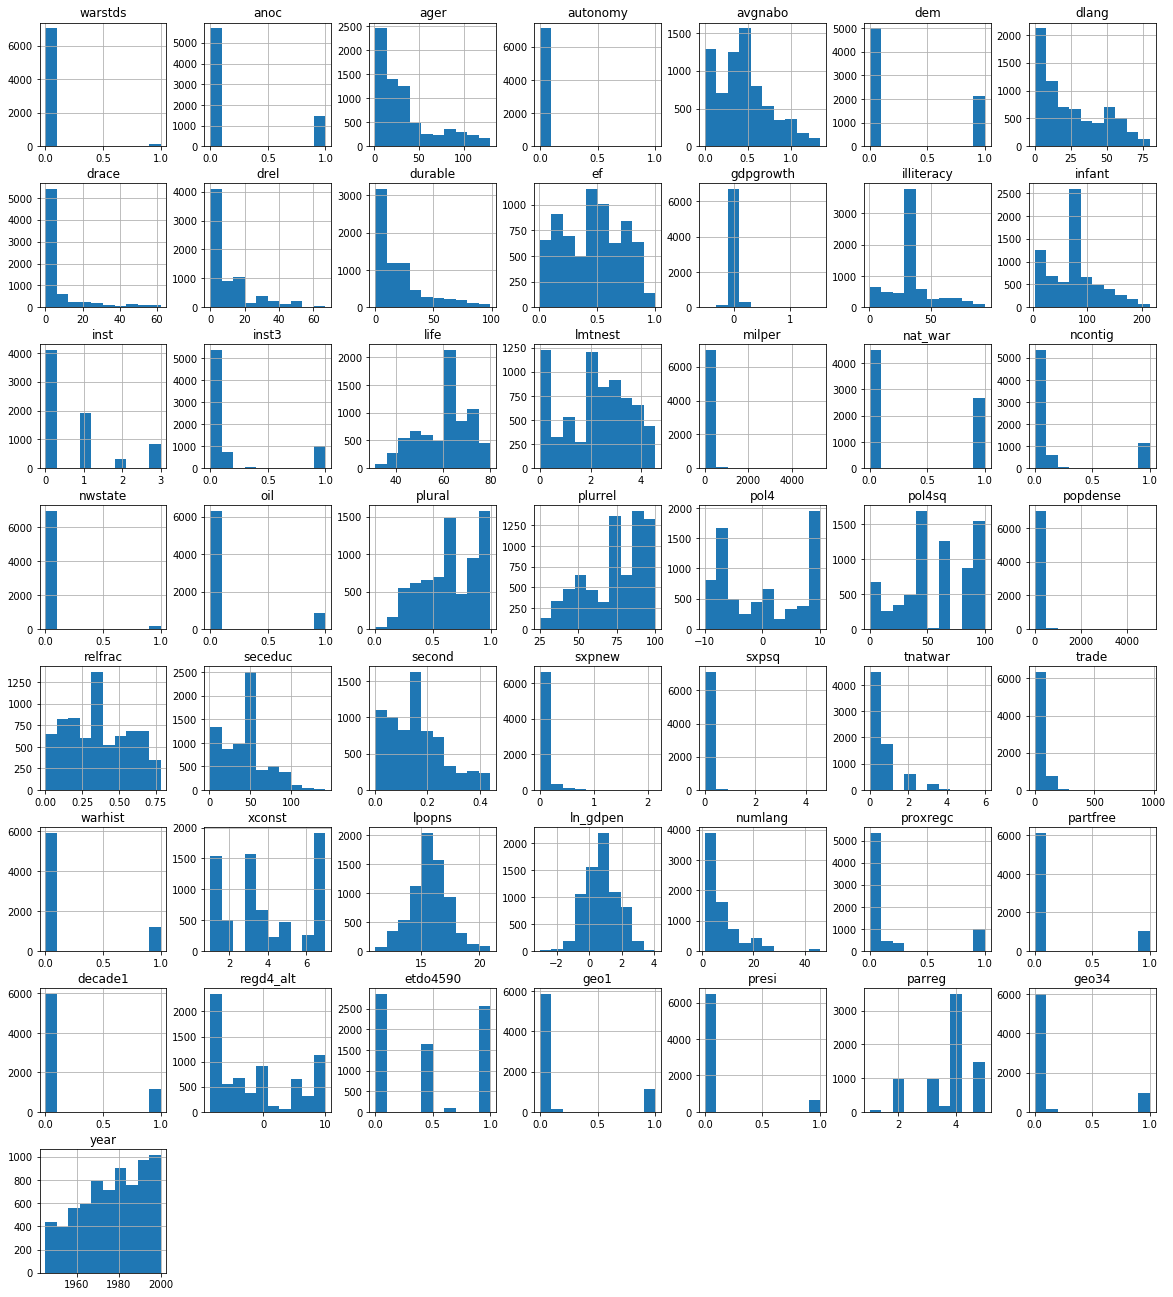

In [17]:
df_onset.hist(figsize=(20,23))
plt.show()

There does not seem to be values out of range, abnormally big values. However, now in the dataset, there could be variables which could be redundant. We will try to see and keep only 1 of those variables. Also, some variables could have no valuable information for this analysis.

For the variables which appear also as squared, we will only keep the squared ones. This affects the `sxpnew` variable and the `pol4` variable. We will drop `numlang`, the number of languages variable, since the linguistic fractionalization is already incorporated in the `dlang` variable. Between `durable` and `proxregc`, only the latter one will be kept since being some preprocessed feature. 

In [18]:
df_onset.drop(columns=['durable', 'pol4', 'sxpnew', 'numlang'], inplace=True) 

### Civil war end dataset definition

Next we will verify if this dataset provides some variable for civil war duration and prepare the dataset for civil war end prediction.

In [19]:
df_on['atwards'].describe()

count    7140.000000
mean        0.125630
std         0.331455
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: atwards, dtype: float64

`atwards` is the variable indicating if a country was at war in a given year. With some data wrangling, `atwards` could be a good variable for civil war duration indication. But it is not very precise ( only years ).

In [20]:
duration = df_on.groupby('id')['atwards'].agg('sum')
duration.describe()

count    187.000000
mean       4.796791
std        8.748050
min        0.000000
25%        0.000000
50%        0.000000
75%        5.000000
max       48.000000
Name: atwards, dtype: float64

The duration of civil wars in years is rather small, and so the time granularity might not be sufficient to produce good estimates of duration. Instead, we will predict, for a given year, if the war has stopped. To that end, we add a new variable, `warend`, which is 1 if the war has ended this year (`atwards` switched from 0 to 1 this year), and 0 if the war is still ongoing (`atwards` is 1). Note that hear we do not drop the variables that were selected for the onset prediction. The reason why is that the prediction is significantly better this way for civil war ending. The prediction of civil war ending is in fact the subject of discussion (on the order of causality) in the end of this project, and thus it does not really matter if the causal factors are chosen well in advance.

In [21]:
# Add a column corresponding to if a civil war ended this year
df_end = df_on[df_on['atwards']==1] 
df_end =  warend_labels('atwards',df_end,df_on)

# Add alpha3 country code
df_end['cowalpha'] = df_end.cowcode.map(stateabb_mapping)
df_end['statename'] = df_end.cowcode.map(statename_mapping)

df_end = df_end[warend_vars+['cowalpha']+['statename']]
df_end.head()

warend  anoc   ager  autonomy  avgnabo  dem  dlang  drace  drel  durable  \
33       0     0  108.0       0.0      0.0    0   70.0    0.0  20.0     13.0   
34       0     1  109.0       0.0      0.0    0   70.0    0.0  20.0      0.0   
35       0     0  110.0       0.0      0.0    0   70.0    0.0  20.0      0.0   
36       0     0  111.0       0.0      0.0    0   70.0    0.0  20.0      1.0   
37       0     0  112.0       0.0      0.0    0   70.0    0.0  20.0      2.0   

          ef  gdpgrowth  illiteracy  infant  inst  inst3       life   lmtnest  \
33  0.750797  -0.002629   82.900002   194.0     0    1.0  40.000000  4.198705   
34  0.750797   0.000803   82.099998   194.0     0    1.0  40.000000  4.198705   
35  0.750797   0.000680   81.699997   194.0     0    1.0  40.000000  4.198705   
36  0.750797   0.000813   82.000000   183.0     0    1.0  40.487801  4.198705   
37  0.750797   0.000831   80.500000   183.0     0    0.0  40.487801  4.198705   

    milper  nat_war  ncontig  nwstate  oil  plural  plurrel      pol4  \
33   143.0        1      0.0      0.0    0    0.38     84.0 -7.000000   
34   110.0        1      0.0      0.0    0    0.38     84.0 -1.024909   
35    89.0        1      0.0      0.0    0    0.38     84.0 -7.000000   
36    40.0        1      0.0      0.0    0    0.38     84.0 -7.000000   
37    43.0        1      0.0      0.0    0    0.38     84.0 -7.000000   

       pol4sq   popdense  relfrac  seceduc  second    sxpnew     sxpsq  \
33  49.000000  23.236290   0.2718      8.0   0.253  0.077570  0.006017   
34  47.211886  23.842110   0.2718      8.0   0.253  0.102470  0.022082   
35  49.000000  24.459810   0.2718      8.0   0.253  0.102335  0.022051   
36  49.000000  25.090099   0.2718     10.0   0.253  0.102302  0.022109   
37  49.000000  25.733120   0.2718     10.0   0.253  0.102233  0.022012   

    tnatwar      trade  warhist    xconst     lpopns  ln_gdpen  numlang  \
33      1.0  26.486080        0  1.000000  16.593708 -0.002002      8.0   
34      1.0  24.713800        0  3.562772  16.601755  0.006976      8.0   
35      1.0  47.573419        0  3.000000  16.609922 -0.034591      8.0   
36      1.0  47.526501        0  3.000000  16.618689 -0.012073      8.0   
37      1.0  47.572445        0  3.000000  16.636055  0.021761      8.0   

        proxregc  partfree  decade1  regd4_alt  etdo4590  geo1  presi  \
33  1.490000e-08         0        0       -7.0       1.0   0.0      0   
34  1.000000e+00         0        0       -5.0       1.0   0.0      0   
35  1.000000e+00         0        0       -6.0       1.0   0.0      0   
36  2.500000e-01         0        0       -7.0       1.0   0.0      0   
37  6.250000e-02         0        0       -4.0       1.0   0.0      0   

      parreg  geo34 cowalpha    statename  
33  4.000000    0.0      AFG  Afghanistan  
34  3.412579    0.0      AFG  Afghanistan  
35  4.000000    0.0      AFG  Afghanistan  
36  4.000000    0.0      AFG  Afghanistan  
37  4.000000    0.0      AFG  Afghanistan

<a id="exploration"/>

## Dataset exploration

In order to get a better of sense of the data at hand and how the civil war onsets are spread across the world, we perform some data exploration here. We will use world maps also later on in the project in order to study wether the predictors found indeed show up on the maps. The idea here is to be convinced that civil wars are still frequent in modern times, and that it is an issue that must be dealt with.

### Map of number of civil war onsets

Here is the map of the number of civil war onsets a country has seen since 1945.

In [123]:
# Group by country and sum to get total of civil war onsets per country
df_numonset = df_on.groupby(['cowcode'])['warstds'].agg('sum').reset_index().set_index(['cowcode']).reset_index()
df_numonset = df_numonset[df_numonset['warstds']>0] # Discard if no onset
df_numonset['cowalpha'] = df_numonset.cowcode.map(stateabb_mapping)
df_numonset['statename'] = df_numonset.cowcode.map(statename_mapping)
df_numonset.rename(columns={'warstds':'Number of civil war onsets'}, inplace=True)
df_numonset.head()

cowcode  Number of civil war onsets cowalpha           statename
3        40                           1      CUB                Cuba
4        41                           1      HAI               Haiti
5        42                           1      DOM  Dominican Republic
10       70                           1      MEX              Mexico
12       90                           3      GUA           Guatemala

In [124]:
fig = px.choropleth(df_numonset, locations="cowalpha",
                    color="Number of civil war onsets", 
                    hover_name="statename",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(height=500,width=800,title='Map of number of civil war onsets',title_x=0)
fig.show()
html = plot(fig, auto_open=False, output_type='div')
with open("../cwonset/_includes/map_onset.html", 'w') as file:
    file.write(html)

The world regions most struck by civil wars are Latin America, Eastern Africa and the Middle East. Some countries, such as Nicaragua India and Iraq have seen up to 3 civil wars since 1945. Seeing such results, geographical, economic and temporal patterns should influence a country going into civil war or not.

### Map of number of years at war
Here is the map of the number of years a country has been in civil war (can span different civil wars).

In [125]:
# Group by country and sum to get total of years at war per country
df_durwar = df_on.groupby(['cowcode'])['atwards'].agg('sum').reset_index().set_index(['cowcode']).reset_index()
df_durwar = df_durwar[df_durwar['atwards']>0] # Discard if no years at war
df_durwar['cowalpha'] = df_durwar.cowcode.map(stateabb_mapping)
df_durwar['statename'] = df_durwar.cowcode.map(statename_mapping)
df_durwar.rename(columns={'atwards':'Years of civil war'}, inplace=True)
df_durwar.head()

cowcode  Years of civil war cowalpha           statename
3        40                   2      CUB                Cuba
4        41                   4      HAI               Haiti
5        42                   1      DOM  Dominican Republic
10       70                   3      MEX              Mexico
12       90                  25      GUA           Guatemala

In [126]:
fig = px.choropleth(df_durwar, locations="cowalpha",
                    color="Years of civil war", 
                    hover_name="statename",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(height=500,width=800,title='Map of number of years spent in civil war conflict',title_x=0)
fig.show()
html = plot(fig, auto_open=False, output_type='div')
with open("../cwonset/_includes/map_duration.html", 'w') as file:
    file.write(html)

Some countries, such as Colombia, have been in civil war for decades. Those are also not necessarily the same ones that have seen the most onsets. Seeing how long civil wars can last, and knowing how destructive they are, the importance of understanding their causal factors is evident.

<a id="onset"/>

## Prediction of civil war onset

In this part, we will firstly predict civil war onset using the 2 methods of interest, Random Forest and Neural Networks. We will then study the predictive power of the two methods by plotting their ROC curves, along with the AUC score. This methods was also used by the authors. The ROC curve is useful in the context of class imbalance since we do not know the threshold for good classification a priori. This metric also gives a good idea of the robustness of the prediction. We will also perform dimensionality reduction on the activations of the last hidden layer of the MLP in order to get a better insight in how this type of model is able to learn non-linear mappings between features and prediction. This kind of approach would also be useful when using inputs of different modalities (visual, temporal). We will then look at the feature importances using permutation importance on a test set. Finally, we will plot some of these important variables on a world map for both values of the dependent variable.

### Train models for civil war onset

**Note** that the output of this cell is **removed** (i.e. by running a blank cell and pasting the code) in order to eliminate the verbose that makes the notebook very long.

In [ ]:
# Train RF and MLP to predict civil war onset and gather predictions and importances
rf_onset,mlp_onset,df_rf_onset_predict,df_mlp_onset_predict,importances_onset = train_models('warstds',df_onset.drop(['year'],axis=1),SEARCH_ITER,DATA_SPLIT,CV,SEED)

### Predictive power comparison

In [121]:
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

# Generate ROC curve and thresholds
fpr_rf_onset, tpr_rf_onset, thr_rf_onset = roc_curve(df_rf_onset_predict.Label, df_rf_onset_predict.Predicted)
fpr_mlp_onset, tpr_mlp_onset, thr_mlp_onset = roc_curve(df_mlp_onset_predict.Label, df_mlp_onset_predict.Predicted)

# Calculate AUC
auc_rf_onset = auc(fpr_rf_onset, tpr_rf_onset)
auc_mlp_onset = auc(fpr_mlp_onset, tpr_mlp_onset)

# Plot
fig.add_trace(go.Scatter(x=fpr_rf_onset, y=tpr_rf_onset, name='Random Forest (AUC = %0.3f)'% auc_rf_onset, mode='lines'))
fig.add_trace(go.Scatter(x=fpr_mlp_onset, y=tpr_mlp_onset, name='Multi Layer Perceptron (AUC = %0.3f)'% auc_mlp_onset, mode='lines'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=800, height=500,
    title="ROC curve for civil war onset"
)
fig.show()
html = plot(fig, auto_open=False, output_type='div')
with open("../cwonset/_includes/roc_onset.html", 'w') as file:
    file.write(html)

The ROC curves yield good results for both approaches, with a slight advantage for RF. In all cases, both approaches are better than the traditional statistical approaches presented in the original paper. As we will see in the rest of the project, MLPs are less powerfull at handling imbalanced data than RFs.

### MLP activations analysis

In [127]:
# Scale whole dataset
df_onset_X = df_onset.drop(['warstds','year'],axis=1)
scaler = StandardScaler().fit(df_onset_X)
df_onset_X = scaler.transform(df_onset_X)

In [128]:
# Retrieve up to second-to-last layer of the trained MLP to generate the embeddings
mlp_onset_enc = keras.models.Sequential([
    mlp_onset.model.layers[0],
    mlp_onset.model.layers[1],
    mlp_onset.model.layers[2]
])

# Clone the model with random weights for control
mlp_onset_enc_u = keras.models.clone_model(mlp_onset_enc)

In [129]:
# Perform dimensionality reduction with t-SNE on the features directly
tsne_f_onset = TSNE(n_components=2,perplexity=30).fit_transform(df_onset_X)
tx_f_onset = tsne_f_onset[:, 0]
ty_f_onset = tsne_f_onset[:, 1]

# Perform dimensionality reduction with t-SNE on the untrained embeddings/activations
tsne_ua_onset = TSNE(n_components=2,perplexity=30).fit_transform(mlp_onset_enc_u.predict(df_onset_X))
tx_ua_onset = tsne_ua_onset[:, 0]
ty_ua_onset = tsne_ua_onset[:, 1]

# Perform dimensionality reduction with t-SNE on the trained embeddings/activations
tsne_a_onset = TSNE(n_components=2,perplexity=30).fit_transform(mlp_onset_enc.predict(df_onset_X))
tx_a_onset = tsne_a_onset[:, 0]
ty_a_onset = tsne_a_onset[:, 1]

In [134]:
fig = make_subplots(rows=1, cols=3,
    subplot_titles=("Features","Untrained activations", "Trained activations"))

# Generate the color labels
color_labels = ['mediumblue' if x is 1 else 'lightsalmon' for x in df_onset['warstds']]

# Add the feature plot
fig.add_trace(go.Scatter(x=tx_f_onset,y=ty_f_onset,mode='markers',marker_color=color_labels,showlegend=False),row=1, col=1)

# Add the untrained activations plot
fig.add_trace(
    go.Scatter(x=tx_ua_onset, y=ty_ua_onset,mode='markers',marker_color=color_labels,showlegend=False),
    row=1, col=2
)

# Add the trained activations plot
fig.add_trace(
    go.Scatter(x=tx_a_onset, y=ty_a_onset,mode='markers',marker_color=color_labels,showlegend=False),
    row=1, col=3
)

# Add color legends
fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                       marker_color='mediumblue',
                       legendgroup='Civil war onset', showlegend=True, name='Civil war onset'))
fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                       marker_color='lightsalmon',
                       legendgroup='No civil war onset', showlegend=True, name='No civil war onset'))

fig.update_layout(height=400, width=800, title_text="Visualization of the datapoints using t-SNE for dimensionality reduction")
fig.show()
html = plot(fig, auto_open=False, output_type='div')
with open("../cwonset/_includes/tsne_onset.html", 'w') as file:
    file.write(html)

Here are the activations of the last hidden layer of the MLP for the dataset. We also use two controls - the features and untrained activations - in order to put into perspective the results, as it is often with ANNs that even untrained networks can have well clustered activations due to the input distribution. Here we see that indeed the trained MLP is able to group the civil war onset datapoints (bottom-right) better than the controls. Still we see that the cluster overlaps with some negative datapoints. This shows that the MLP is able to extract some mapping from the features in order to group somewhat separately the two events (civil war onset and no onset) to make a prediction.

### Feature importance comparison

In [119]:
# Plot feature importance for RF and MLP
fig = px.bar(importances_onset, x="Names", y="Scores", color="Model", title="Permutation importance scores for civil war onset")
fig.update_xaxes(tickangle=45)
fig.update_layout(height=500, width=800)
fig.show()
html = plot(fig, auto_open=False, output_type='div')
with open("../cwonset/_includes/imp_onset.html", 'w') as file:
    file.write(html)

This plot shows the importance of each of the features using permutation importance. Permutation importance on a test set informs on the features that are importance for generalization. Here, two things are important: some features are very important for both models, and some features have contradicting importance even if the two models have similar predicting power. This last points highlights that talking about causality when using machine learning techniques is risky, as different models can leverage differently the features for prediction. However, some features are clearly very important for both models, such as primary commodity exports/GDP squared `sxpsq`, trade as percept of GDP `trade`, autonomous regions `autonomy`, rough terrain `lmtnest`, percentage of illiteracy `illiteracy`, and military power `milper`. This analysis corroborates some of the results of the original paper with the new model. However, some features such as the GDP growth `gdpgrowth` show contradicting predictive power on the test set, which goes against what the original paper shows. Also, whether the state is new or not `nwstate` shows high predictive power in both models, which is novel from the original paper. 

### Map of primary commodity exports/GDP squared `sxpsq`

Here we plot one of the most important features for both values of `warstds` in order to see if countries indeed show different values.

In [118]:
traces = []
buttons = []

# Add a map for the negative class
traces.append(go.Choropleth(
              locations=df_on[df_on['warstds']==0]['cowalpha'], 
              z=df_onset[df_on['warstds']==0]['sxpsq'].astype(float), 
              colorbar_title='Primary commodity exports/GDP (squared)',
              visible= True,
              hovertext=df_on[df_on['warstds']==0]['statename']))
# Add a button for the negative class
buttons.append(dict(label='No civil war onset',
                    method="update",
                    args=[{"visible":[True,False]},
                      {"title":'Primary commodity exports/GDP when no civil war onset occured (squared)'}]))

# Add a map for the positive class
traces.append(go.Choropleth(
              locations=df_on[df_on['warstds']==1]['cowalpha'], 
              z=df_onset[df_on['warstds']==1]['sxpsq'].astype(float), 
              colorbar_title='Primary commodity exports/GDP (squared)',
              visible= False,
              hovertext=df_on[df_on['warstds']==1]['statename']))
# Add a button for the negative class
buttons.append(dict(label='Civil war onset',
                    method="update",
                    args=[{"visible":[False,True]},
                      {"title":'Primary commodity exports/GDP during civil war onset (squared)'}]))

# Initialize
updatemenus = [{"active":0,
                "buttons":buttons,
               }]


# Show figure
fig = go.Figure(data=traces,
                layout=dict(updatemenus=updatemenus))
fig.update_layout(height=500, width=800,title='Primary commodity exports/GDP when no civil war onset occured (squared)',title_x=0)
fig.show()
html = plot(fig, auto_open=False, output_type='div')
with open("../cwonset/_includes/map_gdp_onset.html", 'w') as file:
    file.write(html)

We clearly observe than indeed, countries experiencing a civil war onset have a noteworthy decrease in primary commodity exports/GDP. Peru for instance, has seen, on average, a drop from 0.05 to 0.006, nearly an order of magnitude less.

### Map of illiteracy

Here we plot one of the most important features for both values of `warstds` in order to see if countries indeed show different values.

In [113]:
traces = []
buttons = []

# Add a map for the negative class
traces.append(go.Choropleth(
              locations=df_on[df_on['warstds']==0]['cowalpha'], 
              z=df_onset[df_on['warstds']==0]['illiteracy'].astype(float), 
              colorbar_title='Illiteracy',
              visible= True,
              hovertext=df_on[df_on['warstds']==0]['statename']))
# Add a button for the negative class
buttons.append(dict(label='No civil war onset',
                    method="update",
                    args=[{"visible":[True,False]},
                      {"title":'Illiteracy when no civil war onset occured'}]))

# Add a map for the positive class
traces.append(go.Choropleth(
              locations=df_on[df_on['warstds']==1]['cowalpha'], 
              z=df_onset[df_on['warstds']==1]['illiteracy'].astype(float), 
              colorbar_title='Illiteracy',
              visible= False,
              hovertext=df_on[df_on['warstds']==1]['statename']))
# Add a button for the positive class
buttons.append(dict(label='Civil war onset',
                    method="update",
                    args=[{"visible":[False,True]},
                      {"title":'Illiteracy during civil war onset'}]))

# Initialize
updatemenus = [{"active":0,
                "buttons":buttons,
               }]


# Show figure
fig = go.Figure(data=traces,
                layout=dict(updatemenus=updatemenus))
fig.update_layout(height=500, width=800,title='Illiteracy when no civil war onset occured',title_x=0)
fig.show()
html = plot(fig, auto_open=False, output_type='div')
with open("../cwonset/_includes/map_illiteracy_onset.html", 'w') as file:
    file.write(html)

Similarly, we see that states experiencing a civil war onset have higher rates of illiteracy. One staggering example is that of Afghanistan, where illiteracy increased from 34% to 83% at the time of the onset.

<a id="change"/>

## Analysis of change of civil war onset over the years



### Important features change along the years

As we saw before in the dataset exploration graph, the features of civil war onsets change during the years. In this part we will try to see if there is a difference in the causal aspects of civil war onset over the years. For this we will analyze the feature importances. We will train Random Forest Classifiers and Neural Networks as civil war onset predictors on bins of data of 15 years, evenly spaced of 5 years.

Firstly, we separate the data into bins.

In [22]:
# Separate data into bins of 15 years periods
df_bins = []

for year in np.sort(df_onset['year'].unique()):
    if not year%5 and year != 1945 and year != 1995 and year != 2000 : # 
        df_bins.append(pd.DataFrame(df_onset.loc[around(df_onset['year'],year)].drop(columns='year')))

Next we will train the predictors, and get the feature importances. **Note** that the output of this cell is **removed** (i.e. by running a blank cell and pasting the code) in order to eliminate the verbose that makes the notebook very long.

In [ ]:
# Building predictors and evaluating importances for each bin of 15 years

periods = ['1945 - 1960', '1950 - 1965', '1955 - 1970', '1960 - 1975', '1965 - 1980', '1970 - 1985', '1975 - 1990', '1980 - 1995', '1985 - 2000']
rf_bins = []
mlp_bins = []
rf_predict_bins = []
mlp_predict_bins = []
all_importances= pd.DataFrame()

for i,df in enumerate(df_bins):
  rf,mlp,df_rf_predict,df_mlp_predict,importances = train_models('warstds',df,SEARCH_ITER,DATA_SPLIT,CV,SEED,'bins')
  rf_bins.append(rf)
  mlp_bins.append(mlp)
  rf_predict_bins.append(df_rf_predict)
  mlp_predict_bins.append(df_mlp_predict)
  importances['period'] = periods[i]
  all_importances = all_importances.append(importances)
  print('Bin {}/9'.format(i+1))
print('Finished all bins')

After the prediction, we want to see the performance of each predictor. Since the data is sparse in the bins, the predictors are a bit worse than the main predictor for all the data, especially for some periods.

In [112]:
# Plotting the ROC curves in plotly subplots

fig = make_subplots(rows=3, cols=3, start_cell="top-left", x_title='False positive rate', y_title='True positive rate',
                    subplot_titles=tuple(periods))

for it in range(9):
  
  # Calculate roc_curves
  fpr_rf_change, tpr_rf_change, thr_rf_change = roc_curve(rf_predict_bins[it].Label, rf_predict_bins[it].Predicted)
  fpr_mlp_change, tpr_mlp_change, thr_mlp_change = roc_curve(mlp_predict_bins[it].Label, mlp_predict_bins[it].Predicted)

  # Calculate AUC scores
  auc_rf_change = auc(fpr_rf_change, tpr_rf_change)
  auc_mlp_change = auc(fpr_mlp_change, tpr_mlp_change)

  # Create figure
  fig.add_trace(go.Scatter(x=fpr_rf_change, y=tpr_rf_change, name='Random Forest (AUC = {:.3}'.format(auc_rf_change), mode='lines'),
              row=(it//3)+1, col=(it%3)+1)
  fig.add_trace(go.Scatter(x=fpr_mlp_change, y=tpr_mlp_change, name='Multi Layer Perceptron (AUC = {:.3}'.format(auc_mlp_change), mode='lines'),
              row=(it//3)+1, col=(it%3)+1) 
  fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1, row=(it//3)+1, col=(it%3)+1)


fig.update_layout(height=700, width=800, title_text="ROC curves for civil war onset in each period of 15 years",title_x=0)
fig.show()
html = plot(fig, auto_open=False, output_type='div')
with open("../cwonset/_includes/roc_all.html", 'w') as file:
    file.write(html)

And now we can finally plot the importance features variation along the years. In the first plot, we can see the feature importance on a linear scale, including negative values. This gives an idea on how reliable the feature importances for each bins are. The poor performance models will tend to have less reliable feature importances, and therefore have a lot of negative feature importances. *Je sais pas si on met ce plot dans la datastory*. The second plot is on a logarithmic scale. This is used to compare all the feature importances. We are not interested in the negative ones, since it only indicates the model is not very good.

In [111]:
# Feature importances plot with linear y scale to see how negative some values are

fig = px.bar(all_importances, x="Names", y="Scores", animation_frame='period', color="Model", 
             range_y=[-0.1, 0.1])
fig.update_layout(height=500, width=800,title_text="Permutation scores for civil war onset in different periods",title_x=0)

fig["layout"].pop("updatemenus")
fig.update_xaxes(tickangle=45)
fig.show()
html = plot(fig, auto_open=False, output_type='div')
with open("../cwonset/_includes/imp_slider.html", 'w') as file:
    file.write(html)

In [110]:
# Feature importances plot with log y axis

fig = px.bar(all_importances, x="Names", y="Scores", animation_frame='period', color="Model", 
             log_y=True, range_y=[0.0001, 0.6],
             )
fig.update_layout(height=500, width=800,title_text="Permutation scores for civil war onset in different periods (log)",title_x=0)

fig["layout"].pop("updatemenus")
fig.update_xaxes(tickangle=45)
fig.show()
html = plot(fig, auto_open=False, output_type='div')
with open("../cwonset/_includes/imp_slider_log.html", 'w') as file:
    file.write(html)

### Clustering of the civil war onsets

In the previous analysis, by making slices of *15 years*, we are imposing a period on which there could be a similarity in the feature importance. Now the idea is to cluster the events using the features in order to see if it gives rise to arbitrary periods where the features are similarly important.  

We will select the important features found in the analysis before, in order to permit temporally significant clustering. See below the selected top 20 features. Since the Random Forest models are generally better, we will take all the features which have a permutation importance higher than 0.005 for the Random Forest model. We will add to this the top features of the Multilayer Perceptron models which were not top features in the Random Forest model to complete to 20 features.

In [33]:
df_onset.head()

warstds  anoc       ager  autonomy   avgnabo  dem  dlang  drace  drel  \
0        0     0  34.461765  0.005151  0.432955    0   70.0    0.0  20.0   
1        0     0  34.346348  0.000000  0.045052    0   70.0    0.0  20.0   
2        0     0  77.000000  0.000000  0.030034    0   70.0    0.0  20.0   
3        0     0  78.000000  0.000000  0.022526    0   70.0    0.0  20.0   
4        0     0  79.000000  0.000000  0.022526    0   70.0    0.0  20.0   

         ef  gdpgrowth  illiteracy     infant  inst     inst3       life  \
0  0.750797   0.022562   34.020639  68.655361     1  0.120897  61.348104   
1  0.750797   0.022447   34.129908  68.918002     0  0.000000  61.297733   
2  0.750797   0.022372   34.183272  69.017545     0  0.000000  61.285176   
3  0.750797   0.022239   34.234445  69.126788     0  0.000000  61.252967   
4  0.750797   0.022462   34.164099  68.960291     0  0.000000  61.301547   

    lmtnest      milper  nat_war  ncontig  nwstate  oil  plural  plurrel  \
0  4.198705  121.087366        0      0.0      0.0    0    0.38     84.0   
1  4.198705  121.885359        1      0.0      0.0    0    0.38     84.0   
2  4.198705  122.780608        1      0.0      0.0    0    0.38     84.0   
3  4.198705  118.256427        1      0.0      0.0    0    0.38     84.0   
4  4.198705  122.245074        1      0.0      0.0    0    0.38     84.0   

       pol4sq    popdense  relfrac    seceduc  second     sxpsq   tnatwar  \
0   61.493014  118.554791   0.2718  43.770298   0.253  0.052989  0.443259   
1  100.000000  117.756342   0.2718  43.588363   0.253  0.052663  1.000000   
2  100.000000  118.280656   0.2718  43.538181   0.253  0.052891  2.000000   
3  100.000000  118.325869   0.2718  43.490005   0.253  0.052902  2.000000   
4  100.000000  118.312296   0.2718  43.602238   0.253  0.052706  2.000000   

       trade  warhist    xconst     lpopns  ln_gdpen  proxregc  partfree  \
0  72.881375        0  3.995912  16.094110  0.851709  0.143299         0   
1  72.900089        0  1.000000  16.116295 -1.639897  1.000000         0   
2  72.962880        0  1.000000  16.138290 -1.629641  1.000000         0   
3  73.102449        0  1.000000  16.252539 -1.639897  1.000000         0   
4  72.850389        0  1.000000  16.270645 -1.398367  1.000000         0   

   decade1  regd4_alt  etdo4590  geo1  presi    parreg  geo34  year  
0        0  -0.413956       1.0   0.0      0  3.835219    0.0  1945  
1        0  -3.000000       1.0   0.0      0  4.000000    0.0  1946  
2        0  -3.000000       1.0   0.0      0  4.000000    0.0  1947  
3        0  -3.500000       1.0   0.0      0  4.000000    0.0  1948  
4        0   2.000000       1.0   0.0      0  4.000000    0.0  1949

In [34]:
# Finding top important features for the clustering
top_score_RF = 0.005
top_score_MLP = 0.02
top_nb = 20

topnbfeat_binsRF = all_importances[all_importances['Model'] == 'Random Forest'].sort_values('Scores',ascending=False)['Names'].unique()[:top_nb]
topimpfeat_binsRF = all_importances[all_importances['Model'] == 'Random Forest'].query('Scores > {}'.format(top_score_RF))['Names'].unique()

topnbfeat_binsMLP = all_importances[all_importances['Model'] == 'Multilayer Perceptron'].sort_values('Scores',ascending=False)['Names'].unique()[:top_nb]
topimpfeat_binsMLP = all_importances[all_importances['Model'] == 'Multilayer Perceptron'].query('Scores > {}'.format(top_score_MLP))['Names'].unique()

# Select the top features
top_feat_bins = list(pd.DataFrame({'Names':np.concatenate([topimpfeat_binsRF, topnbfeat_binsMLP])})['Names'].unique()[:20])
print('These are the selected top 20 features: ')
print(top_feat_bins)

These are the selected top 20 features: 
['illiteracy', 'infant', 'sxpsq', 'trade', 'gdpgrowth', 'lmtnest', 'popdense', 'dlang', 'life', 'milper', 'lpopns', 'ln_gdpen', 'regd4_alt', 'dem', 'xconst', 'seceduc', 'avgnabo', 'inst', 'inst3', 'parreg']


Here we want to see which features are binary. For the clustering, the continuous features will be normalized, and the binary features will be kept as they are. For this we inspect the following variables, suspected to be binary.

In [35]:
df_onset.loc[:,['warhist','nwstate','ncontig','ager','nat_war','oil','partfree','decade1','presi','etdo4590','dem','anoc']].describe()

warhist      nwstate      ncontig         ager      nat_war  \
count  7140.000000  7140.000000  7140.000000  7140.000000  7140.000000   
mean      0.171008     0.028103     0.175304    34.082504     0.371569   
std       0.376543     0.159095     0.363599    32.792923     0.483258   
min       0.000000     0.000000     0.000000     1.000000     0.000000   
25%       0.000000     0.000000     0.000000     9.000000     0.000000   
50%       0.000000     0.000000     0.000000    23.000000     0.000000   
75%       0.000000     0.000000     0.154555    45.000000     1.000000   
max       1.000000     1.000000     1.000000   130.000000     1.000000   

               oil     partfree      decade1        presi     etdo4590  \
count  7140.000000  7140.000000  7140.000000  7140.000000  7140.000000   
mean      0.118347     0.142717     0.163305     0.093838     0.470050   
std       0.323042     0.349809     0.369670     0.291623     0.435135   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.452067   
75%       0.000000     0.000000     0.000000     0.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               dem         anoc  
count  7140.000000  7140.000000  
mean      0.301120     0.202381  
std       0.458777     0.401803  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       1.000000     0.000000  
max       1.000000     1.000000

In this part, we define the features to keep, the binary features and we scale the continuous features to prepare the dataset for clustering. 

In [36]:
# Selecting the features which are important in the last analysis 
non_top_feat = list(df_onset.columns.drop(top_feat_bins))
corrupt_feat = ['decade1', 'year', 'warstds'] # add inst ?

year_clust = df_onset.drop(index=df_onset[df_onset['warstds']==0].index)[['year']]
X_clust = df_onset.drop(columns=non_top_feat + corrupt_feat, index=df_onset[df_onset['warstds']==0].index )

# first scale the data, except binary data
bin_vars = ['warhist','geo1','geo34','anoc','nwstate','ncontig','dem','nat_war','oil','partfree','decade1','presi']
vars_to_drop = [var for var in top_feat_bins if var in bin_vars]
num_vars = X_clust.columns.drop(vars_to_drop)
scaled_vars = StandardScaler().fit_transform(X_clust[num_vars].values)
X_clust[num_vars] = scaled_vars

In order to reduce the dimensionality, and to get better clustering, we will apply Principal component analysis, and keep 90% of the explained variance. This reduces the number of components to 12 or 13 *à vérifier*.

In [37]:
# PCA 
keep_exp_var = 0.9

# Find the number of components to keep 90% of explained variance
X_pca = PCA().fit(X_clust) 
exvar = X_pca.explained_variance_ratio_.cumsum()
nb_comp = np.count_nonzero(exvar < keep_exp_var) + 1

X_clust_red = PCA(n_components=nb_comp).fit_transform(X_clust)

We will firstly use the OPTICS algorithm, which is a variation of the DBSCAN algorithm, which chooses the epsilon parameter automatically, We will use it because of its small number of hyperparameters and ability to cluster non globular clusters. We should choose an appropriate distance metric, it seems to work good with the `correlation` metric, which computes the correlation between vectors. Then minPts should be chosen. For this we will plot the silhouette score and the number of outliers the algorithm finds. We do not want too much outliers in the clustering.

In [38]:
# OPTICS algorithm

# Choosing minPts by plotting silhouette score and other metrics
min_samples_search  = range(2,30)
silhouettes = []
outliers = []
reaches = []
Nclusters = []

for samp in min_samples_search:
  Opt = OPTICS(min_samples=samp , metric='correlation') #
  optics_mod = Opt.fit(X_clust_red)
  labels = optics_mod.labels_

  # Number of clusters
  nb_clusters = optics_mod.cluster_hierarchy_.shape[0]
  # Silhouette score
  if nb_clusters > 1:
    score = silhouette_score(X_clust, labels)
  else: score = np.nan
  # outliers 
  n_outliers = np.count_nonzero(labels == -1)
  # sum of reachability distances
  reach = optics_mod.reachability_
  sum_r = np.sum(reach[np.isfinite(reach)])

  silhouettes.append(score)
  outliers.append(n_outliers)
  reaches.append(sum_r)
  Nclusters.append(nb_clusters)

In [108]:
# Plot clustering performance for OPTICS algorithm

fig = make_subplots(rows=2, cols=1, specs=[[{"secondary_y": True}], [{"secondary_y": False}]], 
                    subplot_titles=('Clustering performances', 'Number of clusters'))

fig.add_trace(go.Scatter(x=list(min_samples_search), y=silhouettes,  name="Silhouette score"), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=list(min_samples_search), y=outliers,  name="Number of outliers"), row=1, col=1, secondary_y=True)
fig.add_trace(go.Scatter(x=list(min_samples_search), y=Nclusters, name="Number of clusters"), row=2, col=1, secondary_y=False)

fig.update_layout(xaxis1=dict(title='Minimum number of samples'), 
                  xaxis2=dict(title='Minimum number of samples'), 
                  yaxis1=dict(title='Silhouette score'),
                  yaxis2=dict(title='Number of outliers'),
                  yaxis3=dict(title='Number of clusters'))
fig.update_layout(height=800, width=800, title='Results of OPTICS clustering',title_x=0)


fig.show()
html = plot(fig, auto_open=False, output_type='div')
with open("../cwonset/_includes/optics.html", 'w') as file:
    file.write(html)

The silhouette score is not defined when the clustering results in 1 cluster, therefore the line is not defined in some parts. The clustering is not very good and yields in a lot of outliers. However, a minimum number of samples which yields good results is 19, which results in 2 clusters. Next we will explore clustering with Kmeans. 

In [45]:
cluster_search = range(2,25)
silhouettes_k = []
SSE = []

for clust in cluster_search:
  Km = KMeans(n_clusters=clust, random_state=10)
  kmeans_mod = Km.fit(X_clust_red)
  labels = kmeans_mod.labels_

  # Silhouette score
  score = silhouette_score(X_clust_red, labels)
  # sum of squared errors
  error = kmeans_mod.inertia_

  silhouettes_k.append(score)
  SSE.append(error)

In [104]:
# Plot clustering performance for KMeans algorithm

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=list(cluster_search), y=silhouettes_k,  name="Silhouette score"), secondary_y=False)
fig.add_trace(go.Scatter(x=list(cluster_search), y=SSE,  name="Sum of squared errors"), secondary_y=True)

fig.update_layout(xaxis=dict(title='Number of clusters'),  
                  yaxis1=dict(title='Silhouette score'),
                  yaxis2=dict(title='Sum of squared errors'))
fig.update_layout(height=400, width=800, title='Results of K-Means clustering',title_x=0)
fig.show()

html = plot(fig, auto_open=False, output_type='div')
with open("../cwonset/_includes/kmeans.html", 'w') as file:
    file.write(html)

Here the clustering is a bit better. The best number of clusters seems to be 11. However, it still does not show very high silhouette scores, which means the data does not easily separate into clusters.



Next we will visualize our analyzed clusters using t-SNE. 

In [61]:
# Cluster with the right algorithm and parameter

fin_labels = KMeans(n_clusters=15, random_state=10).fit_predict(X_clust_red)

In [133]:
X_viz_tsne = TSNE(n_components=2, perplexity=12).fit_transform(X_clust)
Viz_df = pd.DataFrame({'First dimension': X_viz_tsne[:,0], 'Second dimension': X_viz_tsne[:,1], 'Cluster label': map(str, fin_labels)})

# Plot the clusters found
fig = px.scatter(Viz_df, x="First dimension", y="Second dimension", color="Cluster label", 
                 color_discrete_sequence=px.colors.qualitative.Vivid ) # change size
fig.update_layout(height=500, width=700,title='Visualizations of the clusters in 2 dimensions using t-SNE',title_x=0)
fig.show()
html = plot(fig, auto_open=False, output_type='div')
with open("../cwonset/_includes/tsne_features.html", 'w') as file:
    file.write(html)

Now that we have clusters, we want to see how the years of the events in theses clusters are distributed. For this we will firstly analyze the mean of each cluster, and compute the 90% confidence interval of the year values in each cluster.

In [64]:
# Analyzing the periods of the clusters

X_clust['Cluster labels'] = fin_labels
year_clust['Cluster labels'] = fin_labels

Cluster_info = year_clust.groupby('Cluster labels').agg('mean')
Cluster_info = Cluster_info.join(year_clust.groupby('Cluster labels')[['year']].apply(CI, nbr_draws=10))
Cluster_info.sort_values('year', inplace=True)
Cluster_info.head()

year  CI lower bound  CI higher bound
Cluster labels                                              
11              1959.500000     1953.783333      1965.829167
4               1961.250000     1957.250000      1965.250000
1               1964.666667     1960.630000      1968.853333
3               1966.000000     1966.000000      1966.000000
10              1970.608696     1965.615217      1971.476087

Here is presented the time of the civil war onsets, grouped into the clusters found previously. 

Text(0.5, 0.98, 'Distribution of the civil war onsets clusters')

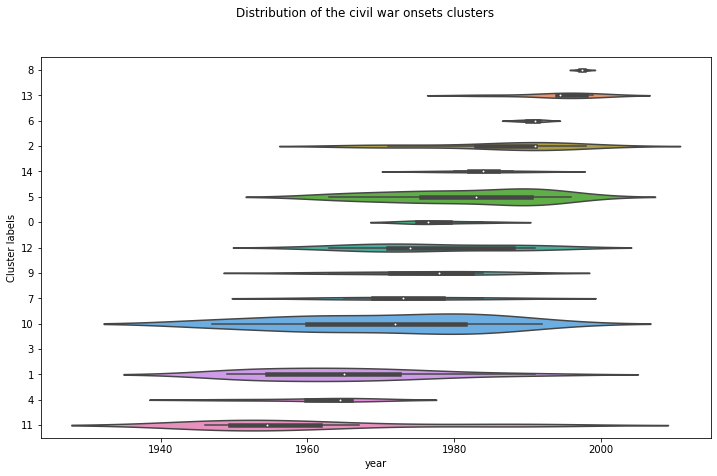

In [132]:
# Plotting the periods of the clusters

df_plot = year_clust.groupby('Cluster labels')

fig, ax = plt.subplots(figsize=(12,7))
sns.violinplot(x='year', y='Cluster labels', data=year_clust, order=list(Cluster_info.sort_values('year', ascending=False).index.values), 
               orient="h", scale='count', ax=ax)
fig.suptitle('Distribution of the civil war onsets clusters')

We see on this plot, that the clusters actually range over quite some periods. For some clusters, they are quite narrow in the time range. This would indeed mean that we found some civil war onsets which had similar causes due to their period of onset. However, the clusters are not timely separated. This could be due to various things. Firstly, we found similar causes in the civil war onsets, and these causes could spread over a wide range of years, or these causes could have no relation with temporality. It could also be that the data is not easily clusterable, and the clusters found are not very reliable.

Next are the violin plots done with plotly.

In [107]:
fig = go.Figure()
fig.update_yaxes(type='category')
for clust in list(Cluster_info.sort_values('year', ascending=True).index.values):
    fig.add_trace(go.Violin(x=year_clust['year'][year_clust['Cluster labels'] == clust],
                            y=year_clust['Cluster labels'][year_clust['Cluster labels'] == clust],
                            name="Cluster "+str(clust),
                            orientation='h',
                            scalemode='count'))
fig.update_layout(height=500, width=800,title='Distribution of the civil war onsets clusters')
fig.show()
html = plot(fig, auto_open=False, output_type='div')
with open("../cwonset/_includes/violin.html", 'w') as file:
    file.write(html)

In [60]:
print(list(map(str,list(Cluster_info.sort_values('year', ascending=False).index.values))))

['6', '2', '1', '10', '4', '11', '12', '3', '8', '5', '9', '7', '0']


<a id="end"/>

## Prediction of civil war end

In this part, we will firstly predict civil war ending using the 2 methods of interest, Random Forest and Neural Networks. The idea is to predict, during war, if the war will end this year. We will then study the predictive power of the two methods by plotting their ROC curves, along with the AUC score. This methods was also used by the authors. The ROC curve is useful in the context of class imbalance since we do not know the threshold for good classification a priori. This metric also gives a good idea of the robustness of the prediction. We will also perform dimensionality reduction on the activations of the last hidden layer of the MLP in order to get a better insight in how this type of model is able to learn non-linear mappings between features and prediction. This kind of approach would also be useful when using inputs of different modalities (visual, temporal). We will then look at the feature importances using permutation importance on a test set. Finally, we will plot some of these important variables on a world map for both values of the dependent variable.

### Train models for civil war end

**Note** that the output of this cell is **removed** (i.e. by running a blank cell and pasting the code) in order to eliminate the verbose that makes the notebook very long.

In [ ]:
# Train RF and MLP to predict civil war end and gather predictions and importances
rf_end,mlp_end,df_rf_end_predict,df_mlp_end_predict,importances_end = train_models('warend',df_end.drop(["cowalpha","statename"],axis=1),SEARCH_ITER,DATA_SPLIT,CV,SEED)

### Predictive power comparison

In [91]:
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

# Generate ROC curve and thresholds
fpr_rf_end, tpr_rf_end, thr_rf_end = roc_curve(df_rf_end_predict.Label, df_rf_end_predict.Predicted)
fpr_mlp_end, tpr_mlp_end, thr_mlp_end = roc_curve(df_mlp_end_predict.Label, df_mlp_end_predict.Predicted)

# Calculate AUC
auc_rf_end = auc(fpr_rf_end, tpr_rf_end)
auc_mlp_end = auc(fpr_mlp_end, tpr_mlp_end)

# Plot
fig.add_trace(go.Scatter(x=fpr_rf_end, y=tpr_rf_end, name='Random Forest (AUC = %0.3f)'% auc_rf_end, mode='lines'))
fig.add_trace(go.Scatter(x=fpr_mlp_end, y=tpr_mlp_end, name='Multi Layer Perceptron (AUC = %0.3f)'% auc_mlp_end, mode='lines'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=800, height=500,
    
)
fig.update_layout(title='ROC curve for civil war end',title_x=0)

fig.show()
html = plot(fig, auto_open=False, output_type='div')
with open("../cwonset/_includes/roc_end.html", 'w') as file:
    file.write(html)

The ROC curves yield good results for the RF approach, and rather poor results for the MLP (yet better than random). This result is probably due to the difficulty of MLP to manipulate class imbalance, even when some weightings are explicitly added in the lost function, like we did. Random Forests, on the other hand, are very powerful at doing so. In the context of this project, we also experimented with Autoencoders, which are good alternatives for dealing with class imbalance. Here, the "anomaly" (classical use of autoencoders) was the end of civil war. The ROC curve for different values of the reconstruction error threshold was actually better than for the MLP. However we did not wish to present the results here for one reason: interpreting feature importance, which is the goal of this project, is not straightforward since the model is trained only on negative examples and would have needed much more work to relate to causality (one idea was to use the features yielding the most reconstruction error for the positive case, the issue being that the features found were very different from the RF model). However this could be a nice extension to this project. 

### MLP activation analysis

In [77]:
# Scale whole dataset
df_end_X = df_end.drop(['warend','cowalpha','statename'],axis=1)
scaler = StandardScaler().fit(df_end_X)
df_end_X = scaler.transform(df_end_X)

In [78]:
# Retrieve up to second-to-last layer of the trained MLP to generate the embeddings
mlp_end_enc = keras.models.Sequential([
    mlp_end.model.layers[0],
    mlp_end.model.layers[1],
    mlp_end.model.layers[2]
])

# Clone the model with random weights for control
mlp_end_enc_u = keras.models.clone_model(mlp_end_enc)

In [79]:
# Perform dimensionality reduction with t-SNE on the features directly
tsne_f_end = TSNE(n_components=2,perplexity=30).fit_transform(df_end_X)
tx_f_end = tsne_f_end[:, 0]
ty_f_end = tsne_f_end[:, 1]

# Perform dimensionality reduction with t-SNE on the untrained embeddings/activations
tsne_ua_end = TSNE(n_components=2,perplexity=30).fit_transform(mlp_end_enc_u.predict(df_end_X))
tx_ua_end = tsne_ua_end[:, 0]
ty_ua_end = tsne_ua_end[:, 1]

# Perform dimensionality reduction with t-SNE on the trained embeddings/activations
tsne_a_end = TSNE(n_components=2,perplexity=30).fit_transform(mlp_end_enc.predict(df_end_X))
tx_a_end = tsne_a_end[:, 0]
ty_a_end = tsne_a_end[:, 1]

In [99]:
fig = make_subplots(rows=1, cols=3,
    subplot_titles=("Features","Untrained activations", "Trained activations"))

# Generate the color labels
color_labels = ['mediumblue' if x is 1 else 'lightsalmon' for x in df_end['warend']]

# Add the feature plot
fig.add_trace(go.Scatter(x=tx_f_end,y=ty_f_end,mode='markers',marker_color=color_labels,showlegend=False),row=1, col=1)

# Add the untrained activations plot
fig.add_trace(
    go.Scatter(x=tx_ua_end, y=ty_ua_end,mode='markers',marker_color=color_labels,showlegend=False),
    row=1, col=2
)

# Add the trained activations plot
fig.add_trace(
    go.Scatter(x=tx_a_end, y=ty_a_end,mode='markers',marker_color=color_labels,showlegend=False),
    row=1, col=3
)

# Add color legends
fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                       marker_color='mediumblue',
                       legendgroup='Civil war end', showlegend=True, name='Civil war end'))
fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                       marker_color='lightsalmon',
                       legendgroup='Civil war', showlegend=True, name='Civil war'))

fig.update_layout(height=400, width=800, title_text="Visualization of the datapoints using t-SNE for dimensionality reduction",title_x=0)
fig.show()
html = plot(fig, auto_open=False, output_type='div')
with open("../cwonset/_includes/tsne_end.html", 'w') as file:
    file.write(html)

Here are the activations of the last hidden layer of the MLP for the dataset. We also use two controls - the features and untrained activations - in order to put into perspective the results, as it is often with ANNs that even untrained networks can have well clustered activations due to the input distribution. Here we see that the trained MLP is able to group the civil war onset datapoints (bottom-right) better than the controls. Still we see that the cluster overlaps with some negative datapoints. This shows that the MLP is able to extract some mapping from the features in order to group somewhat separately the two events (civil war end and no end) to make a prediction.

### Feature importance comparison

In [94]:
# Plot feature importance for RF and MLP
fig = px.bar(importances_end, x="Names", y="Scores", color="Model", title="Permutation importance scores for civil war end")
fig.update_xaxes(tickangle=45)
fig.update_layout(height=500, width=800)
fig.show()
html = plot(fig, auto_open=False, output_type='div')
with open("../cwonset/_includes/imp_end.html", 'w') as file:
    file.write(html)

Here we see that even if the MLP has less predictive power, the feature importances are very similar. Similarly to civil war onset, economical factors are again very important. This last points needs to be put into perspective: the reason is that it is difficult, because of how the dataset is made (in bins of years), to know what is the order of causality here: is the ending of the war due to large numbers of primary commodity exports/GDP, boosting the economy and assuaging the minds leading to the end of the conflict, or are the good numbers following the end of the war, since the economy can now thrive again. We cannot know this from this dataset, but looking at smaller time bins (months) would help us in understanding the ending of conflicts better.

### Map of sxpsq

In [97]:
traces = []
buttons = []

# Add a map for the negative class
traces.append(go.Choropleth(
              locations=df_end[df_end['warend']==0]['cowalpha'], 
              z=df_end[df_end['warend']==0]['sxpsq'].astype(float), 
              colorbar_title='Primary commodity exports/GDP (squared)',
              visible= True,
              hovertext=df_end[df_end['warend']==0]['statename']))
# Add a button for the negative class
buttons.append(dict(label='Civil war',
                    method="update",
                    args=[{"visible":[True,False]},
                      {"title":'Primary commodity exports/GDP during civil war (squared)'}]))

# Add a map for the positive class
traces.append(go.Choropleth(
              locations=df_end[df_end['warend']==1]['cowalpha'], 
              z=df_end[df_end['warend']==1]['sxpsq'].astype(float), 
              colorbar_title='Primary commodity exports/GDP (squared)',
              visible= False,
              hovertext=df_end[df_end['warend']==1]['statename']))
# Add a button for the positive class
buttons.append(dict(label='Civil war end',
                    method="update",
                    args=[{"visible":[False,True]},
                      {"title":'Primary commodity exports/GDP upon civil war end (squared)'}]))

# Initialize
updatemenus = [{"active":0,
                "buttons":buttons,
               }]


# Show figure
fig = go.Figure(data=traces,
                layout=dict(updatemenus=updatemenus))
fig.update_layout(height=500, width=800,title='Primary commodity exports/GDP during civil war (squared)',title_x=0)
fig.show()
html = plot(fig, auto_open=False, output_type='div')
with open("../cwonset/_includes/map_gdp_end.html", 'w') as file:
    file.write(html)

It is clear here that primary commodity exports/GDP are on the rise in years where the civil war stops. For instance, Mali shows an increase on average from 0.01 to 0.05 (5x increase). Is it due to the end of the civil war, or has this triggered the end of the civil war? Good question!